In [1]:
"""%load_ext autoreload
%autoreload 2
%load_ext wurlitzer
"""
import sys
import json
from ruamel.yaml import YAML
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import gc

import lossmaps as lm

from scipy.constants import c as clight

from cpymad.madx import Madx

import xpart as xp
import xtrack as xt
import xobjects as xo
import xdyna as xd
import xcoll as xc
# import xboinc as xb

import subprocess
import os

No pytransport functionality
No pytransport functionality


In [2]:
# context = xo.ContextCpu(omp_num_threads=26)
context = xo.ContextCpu()
context.allow_prebuilt_kernels = False
context.allow_prebuilt_kernels

False

### Crystal Setup

In [3]:
branch_name = 'main'
#branch_name = 'NoMoreManager'
#branch_name = 'KayStatus'
#branch_name = 'ForKayAsSixtrack'
#branch_name = 'ForKayBetterEtaWithTransition'
#branch_name = 'ForKayBetterEtaWithoutTransition'

In [31]:
if branch_name in ['KayStatus', 'ForKayAsSixtrack', 'ForKayBetterEtaWithTransition', 'ForKayBetterEtaWithoutTransition']:
    coll = xc.EverestCrystal(length=0.002, material=xc.materials.SiliconCrystal, bending_angle=144e-6,
                            xdim=0.002, ydim=0.05, side='+', lattice='strip', jaw=0.001)
elif branch_name == 'main':
    coll = xc.EverestCrystal(length=0.002, material=xc.materials.SiliconCrystal, bending_angle=144e-6,
                            xdim=0.002, ydim=0.05, side='+', lattice='strip', jaw=0.001)
elif branch_name == 'NoMoreManager':
    coll = xc.EverestCrystal(length=0.002, material=xc.materials.SiliconCrystal, bending_angle=144e-6,
                            width=0.002, height=0.05, side='+', lattice='strip', jaw=0.001)

xp_crit_comp = 9.130328408646464e-06

NameError: Invalid keyword argument `xdim`

### Tracking

In [ ]:
tot_part = 0

for i in range(300):
    
    print('\nIteration: ', i, ",    range: ", (-50+i), ' , ',(-50+i), 'urad')
    num_part = int(3.33334e6)
    x_init   = np.random.normal(loc=1.5e-3, scale=75.e-6, size=num_part)
    px_init  = np.random.uniform(low=(-50+i)*1.e-6, high=(-51+i)*1.e-6, size=num_part)
    y_init   = np.random.normal(loc=0., scale=1e-6, size=num_part)
    py_init  = np.random.normal(loc=0., scale=1.e-8, size=num_part)
    part = xp.Particles(x=x_init, px=px_init, y=y_init, py=py_init, delta=0, p0c=4e11)

    del x_init, px_init, y_init, py_init
    gc.collect()

    part_init_px = part.px.copy().astype('float32')


    %time coll.track(part)
    # Sort particles again
    part.sort(interleave_lost_particles=True)

    alive = (part.state > 0 )
    df = pd.DataFrame({'part_init_px': part_init_px[alive], 'part_Diff_px': part.px[alive].astype('float32') - part_init_px[alive]})
    mask =  (df.part_Diff_px < 200.e-6) & ( df.part_Diff_px > -75.e-6)

    del part, part_init_px
    gc.collect()

    # if i ==0:
    df[mask].to_hdf(Path( Path.cwd()/ 'slices', f'branch_{branch_name}_{-50+i}urad.h5'), key='px', format='table', mode='a',
                complevel=9, complib='blosc')
    # else:
    #     store = pd.HDFStore(Path(Path.cwd(), f'branch_{branch_name}_{-50+i}urad.h5'))
    #     store.append('px', df)
    #     store.close()
    
    tot_part += len(df)
    print('N part: ' ,len(df))
    
    del df
    gc.collect()


print('Total particles: ', tot_part)



Iteration:  0 ,    range:  -50  ,  -50 urad
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
CPU times: user 1.19 s, sys: 21.1 ms, total: 1.21 s
Wall time: 3.41 s
N part:  3326187

Iteration:  1 ,    range:  -49  ,  -49 urad
CPU times: user 1.18 s, sys: 1.71 ms, total: 1.18 s
Wall time: 1.18 s
N part:  3326392

Iteration:  2 ,    range:  -48  ,  -48 urad
CPU times: user 1.15 s, sys: 182 µs, total: 1.15 s
Wall time: 1.15 s


KeyboardInterrupt: 

In [ ]:
coll.critical_angle

8.414711910903146e-06

In [ ]:
print('Total particles:  ', tot_part)


Check total particles:   True


### Loading


In [5]:
file_list = os.listdir('./slices')
file_list = [f for f in file_list if branch_name in f]
files = {}
for file in file_list:
    files[int(file.split('_')[-1].split('u')[0])-1] = file

In [6]:
files

{-51: 'branch_main_-50urad.h5',
 -50: 'branch_main_-49urad.h5',
 -49: 'branch_main_-48urad.h5',
 -48: 'branch_main_-47urad.h5',
 -47: 'branch_main_-46urad.h5',
 -46: 'branch_main_-45urad.h5',
 -45: 'branch_main_-44urad.h5',
 -44: 'branch_main_-43urad.h5',
 -43: 'branch_main_-42urad.h5',
 -42: 'branch_main_-41urad.h5',
 -41: 'branch_main_-40urad.h5',
 -40: 'branch_main_-39urad.h5',
 -39: 'branch_main_-38urad.h5',
 -38: 'branch_main_-37urad.h5',
 -37: 'branch_main_-36urad.h5',
 -36: 'branch_main_-35urad.h5',
 -35: 'branch_main_-34urad.h5',
 -34: 'branch_main_-33urad.h5',
 -33: 'branch_main_-32urad.h5',
 -32: 'branch_main_-31urad.h5',
 -31: 'branch_main_-30urad.h5',
 -30: 'branch_main_-29urad.h5',
 -29: 'branch_main_-28urad.h5',
 -28: 'branch_main_-27urad.h5',
 -27: 'branch_main_-26urad.h5',
 -26: 'branch_main_-25urad.h5',
 -25: 'branch_main_-24urad.h5',
 -24: 'branch_main_-23urad.h5',
 -23: 'branch_main_-22urad.h5',
 -22: 'branch_main_-21urad.h5',
 -21: 'branch_main_-20urad.h5',
 -20: 'b

In [7]:
def load(low_lim, high_lim = None, files=files, perc = 1):
    

    with pd.HDFStore(Path(Path.cwd(), 'slices', files[low_lim]), 'r') as store:
        total_rows = store.get_storer('px').nrows
    store.close()
    rows_to_read = int(total_rows * perc)
    df = pd.read_hdf(Path(Path.cwd(), 'slices', files[low_lim]), key='px', start=0, stop=rows_to_read)

    if high_lim is not None:
        for i in range(low_lim+1, high_lim):
            with pd.HDFStore(Path(Path.cwd(), 'slices', files[i]), 'r') as store:
                total_rows = store.get_storer('px').nrows
            store.close()
            rows_to_read = int(total_rows * perc)
            df = pd.concat([df, pd.read_hdf(Path(Path.cwd(), 'slices', files[i]), key='px', start=0, stop=rows_to_read)])

    return df

### Plotting

##### Finding critical angle

In [27]:
df = load(-11, 11)

Text(0.5, 1.0, 'Branch: NoMoreManager')

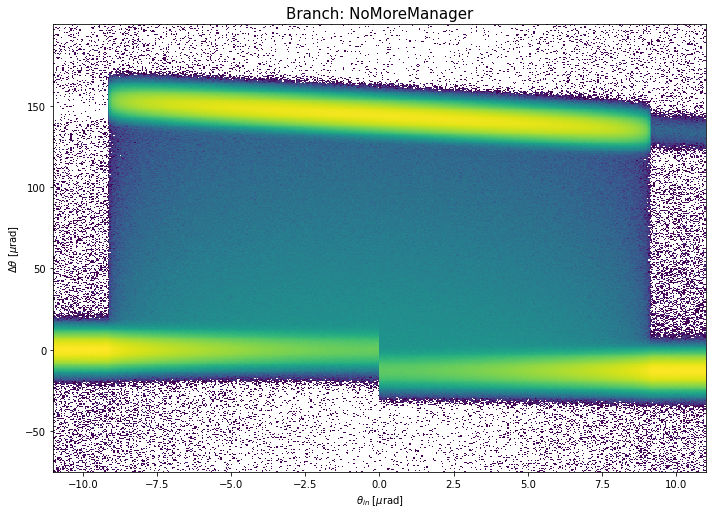

In [9]:
plt.figure(figsize=(10,7))

_ = plt.hist2d(df.px_in*1.e6, df.px_diff*1.e6, 500, norm=mpl.colors.LogNorm())
#plt.xlim(-30, 180)
#plt.ylim(-55, 205)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()
plt.title(f'Branch: {branch_name}', fontsize=15)
#plt.savefig(f"Distribution_{branch_name}.png", dpi=300)

In [28]:
mask_zoom =  (df.px_diff > 120.e-6) & (df.px_in > -10e-6) & (df.px_in < -7e-6) 


print("Scan.. ")
lower = -8.5
upper = -10.5
steps = np.linspace(lower, upper, -int((upper-lower)/0.1)+1)
lens = []
idx = 0
for i in steps:
    m = mask_zoom & (df.px_in > i*1.e-6) & (df.px_in < (i+0.1)*1.e-6)
    lens.append(len(df.px_in[m]))
    print('range: [', i, ', ', i+0.1, ']', lens[idx], lens[idx]-lens[idx-1] if idx > 0 else lens[idx])
    if lens[idx] <100 and lens[idx-1] > 100:
        lim_idx = idx-1
    idx += 1

print('\nFine in [', steps[lim_idx],', ', steps[lim_idx-1], ']')
lens_fine = []
idx = 0
fine_steps =  np.linspace(steps[lim_idx-1],steps[lim_idx], 11)
for i in fine_steps:
    print(i, i+0.01)
    m = mask_zoom & (df.px_in > i*1.e-6) & (df.px_in < (i+0.01)*1.e-6)
    lens_fine.append(len(df.px_in[m]))
    print('range: [', i, ', ', i+0.01, ']', lens_fine[idx], lens_fine[idx]-lens_fine[idx-1] if idx > 0 else lens[idx])
    if lens_fine[idx] <10 and lens_fine[idx-1] > 10:
        lim_idx_fine = idx-1
    idx += 1

print(fine_steps[lim_idx_fine-1], fine_steps[lim_idx_fine])

xp_crit = abs(np.mean(fine_steps[lim_idx_fine-1:lim_idx_fine+1]))*1e-6
print('\n\nxp_crit: ', xp_crit, '\t xp_crit_comp: ', xp_crit_comp, '\t diff: ', xp_crit - xp_crit_comp)




Scan.. 
range: [ -8.5 ,  -8.4 ] 100788 100788
range: [ -8.6 ,  -8.5 ] 93432 -7356
range: [ -8.7 ,  -8.6 ] 85393 -8039
range: [ -8.8 ,  -8.700000000000001 ] 76632 -8761
range: [ -8.9 ,  -8.8 ] 65467 -11165
range: [ -9.0 ,  -8.9 ] 52971 -12496
range: [ -9.1 ,  -9.0 ] 34558 -18413
range: [ -9.2 ,  -9.1 ] 4385 -30173
range: [ -9.3 ,  -9.200000000000001 ] 71 -4314
range: [ -9.4 ,  -9.3 ] 56 -15
range: [ -9.5 ,  -9.4 ] 53 -3
range: [ -9.6 ,  -9.5 ] 48 -5
range: [ -9.7 ,  -9.6 ] 62 14
range: [ -9.8 ,  -9.700000000000001 ] 50 -12
range: [ -9.9 ,  -9.8 ] 63 13
range: [ -10.0 ,  -9.9 ] 48 -15
range: [ -10.1 ,  -10.0 ] 0 -48
range: [ -10.2 ,  -10.1 ] 0 0
range: [ -10.3 ,  -10.200000000000001 ] 0 0
range: [ -10.4 ,  -10.3 ] 0 0
range: [ -10.5 ,  -10.4 ] 0 0

Fine in [ -9.2 ,  -9.1 ]
-9.1 -9.09
range: [ -9.1 ,  -9.09 ] 2311 100788
-9.11 -9.1
range: [ -9.11 ,  -9.1 ] 1892 -419
-9.12 -9.11
range: [ -9.12 ,  -9.11 ] 1571 -321
-9.129999999999999 -9.12
range: [ -9.129999999999999 ,  -9.12 ] 881 -690
-9.

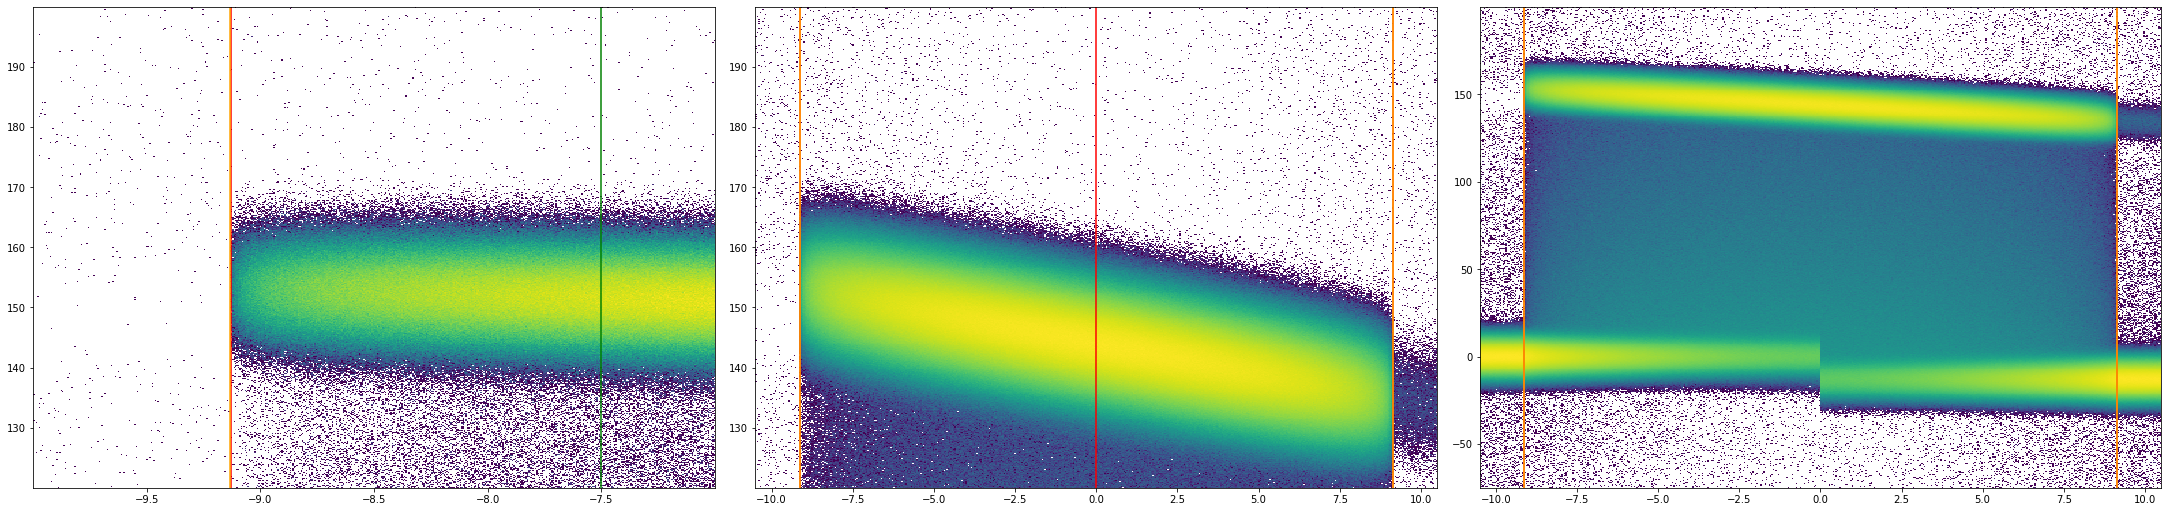

In [16]:
fig, ax= plt.subplots(1,3,layout='constrained',  figsize=(30,7))

_ = ax[0].hist2d(df.px_in[mask_zoom]*1.e6, df.px_diff[mask_zoom]*1.e6, 500, norm=mpl.colors.LogNorm())

#plt.axvline(0, color='red')
#plt.axvline(xp_crit_comp*1.e6, color='red')
ax[0].axvline(-xp_crit_comp*1.e6, color='red')
ax[0].axvline(-10.5, color='g')
ax[0].axvline(-7.5, color='g')
ax[0].axvline(-xp_crit*1.e6, color='orange')


mask_zoom2 = (df.px_diff > 120.e-6) &  (df.px_in > -10.5e-6) & (df.px_in < 10.5e-6) 

_ = ax[1].hist2d(df.px_in[mask_zoom2]*1.e6,  df.px_diff[mask_zoom2]*1.e6, 500, norm=mpl.colors.LogNorm())

ax[1].axvline(0, color='red')
ax[1].axvline(xp_crit_comp*1.e6, color='red')
ax[1].axvline(-xp_crit_comp*1.e6, color='red')
ax[1].axvline(-xp_crit*1.e6, color='orange')
ax[1].axvline(xp_crit*1.e6, color='orange')

mask_zoom3 =   (df.px_in > -10.5e-6) & (df.px_in < 10.5e-6) 
_ = ax[2].hist2d(df.px_in[mask_zoom3]*1.e6, df.px_diff[mask_zoom3]*1.e6, 500, norm=mpl.colors.LogNorm())
ax[2].axvline(xp_crit_comp*1.e6, color='red')
ax[2].axvline(-xp_crit_comp*1.e6, color='red')
ax[2].axvline(-xp_crit*1.e6, color='orange')
ax[2].axvline(xp_crit*1.e6, color='orange')




##### Channeling Efficiency

In [17]:
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit(data):

    hist, bins = np.histogram(data, bins=100)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    initial_guess = [np.max(hist), np.mean(data), np.std(data)]
    popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)
    return popt

def fit_gaussian(data, ax, xlims = None, return_fit = False):
  
    fit_data = fit(data)
    
    if xlims is None:
        xmin, xmax = ax.get_xlim()
    else:
        xmin, xmax = xlims[0], xlims[1]

    hist_values = np.array([rect.get_height() for rect in ax.patches])
    bin_edges = np.array([rect.get_x() for rect in ax.patches])

    hist_values = hist_values[np.where(bin_edges >= min(data))[0][0]:]
    bin_edges = [i for i in bin_edges if i >= min(data)]

    x = np.linspace(xmin, xmax, len(hist_values))

    # Calculate the area of the histogram
    bin_widths = np.diff(bin_edges)  
    bin_widths = np.append(bin_widths, 0) 
    hist_area = np.sum(hist_values * bin_widths) 

    tmp_y = gaussian(x, fit_data[0], fit_data[1], fit_data[2])
    funct_area = np.trapz(tmp_y, x=x)

    ax.plot(x, gaussian(x, fit_data[0]/funct_area*hist_area, fit_data[1], fit_data[2]), 'g', linestyle = '-', linewidth=2)
    print('mean: ', fit_data[1], 'std: ', fit_data[2])

    if return_fit:
        return fit_data

In [21]:
checks = False

if checks:

    mask_ch = (df.px_in < xp_crit) & (df.px_in > -xp_crit) 

    plt.figure()
    _ = plt.hist2d(df.px_in[mask_ch]*1.e6,df.px_diff[mask_ch]*1.e6, 500, norm=mpl.colors.LogNorm())
    plt.xlim(-15, 15)
    plt.ylim(-55, 205)
    plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
    plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
    plt.tight_layout()

    plt.figure()
    _ = plt.hist(df.px_diff[mask_ch]*1.e6, bins=500,)

    fig, ax = plt.subplots()
    fit_lim = 120e-6
    fit_mask = (df.px_diff > fit_lim) & mask_ch
    ax.hist(df.px_diff[fit_mask], 393)
    fit_gaussian(df.px_diff[fit_mask], ax)



mean:  0.00014397905779151165 std:  6.744339416483864e-06
Chann efficiency:  0.629551251245573


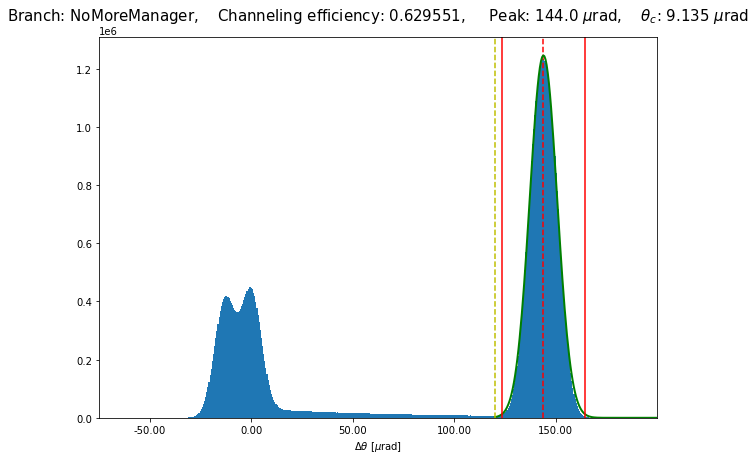

In [29]:
fig, ax = plt.subplots(figsize=(10,7))

mask_ch = (df.px_in < xp_crit) & (df.px_in > -xp_crit) 
#x = df.px_in[mask_ch]*1.e6
ang_defl = df.px_diff[mask_ch]
del mask_ch
gc.collect()

_ = ax.hist(ang_defl, 500)
ax.axvline(coll.bending_angle, color='r', linestyle='--')
fit_lim = 120e-6
fit_param = fit_gaussian(ang_defl[ang_defl > fit_lim], ax, xlims = (fit_lim, max(ang_defl)), return_fit=True)

sig = fit_param[2]
peak = fit_param[1]
ax.axvline(fit_lim, color='y', linestyle='--')
ax.axvline((coll.bending_angle+3*sig), color='r')
ax.axvline((coll.bending_angle-3*sig), color='r')


ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e6:.{2}f}" for x_tick in ax.get_xticks()])
ch = len(ang_defl[(ang_defl>coll.bending_angle-3*sig)&(ang_defl<coll.bending_angle+3*sig)])
print("Chann efficiency: ", ch/len(ang_defl))
ax.set_title(f'Branch: {branch_name},    Channeling efficiency: {ch/len(ang_defl):.6f},     Peak: {peak*1e6:.4}'+r' $\mu$rad'+r',    $\theta_c$:'+f' {xp_crit*1e6:.4}'+r' $\mu$rad',  fontsize=15)
ax.set_xlim(min(ang_defl), max(ang_defl))
# ax.set_xlim(min(data[m]), max(data[m]))
ax.set_xlabel(r'$\Delta\theta$ [$\mu$rad]')
#fig.tight_layout()
fig.savefig(f"Channeling_efficiency_{branch_name}.png", dpi=300)

chann efficiency 
- MAIN: 0.6547 (22 min)
- NOMOREMANAGER: 

##### 2D plots

In [8]:
df = load(min(files.keys()), max(files.keys()), perc=0.19) 

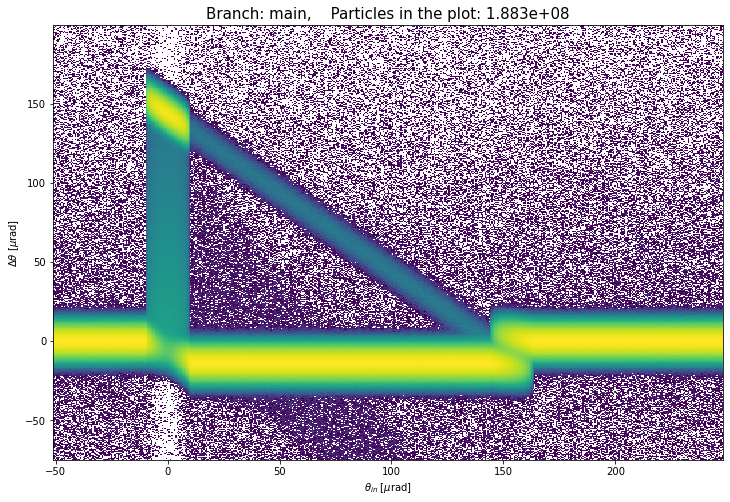

: 

In [9]:
plt.figure(figsize=(12,8))

_ = plt.hist2d(df.px_in*1.e6, df.px_diff*1.e6, 500, norm=mpl.colors.LogNorm())
#plt.xlim(-30, 180)
#plt.ylim(-55, 205)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
#plt.tight_layout()
plt.title(f'Branch: {branch_name},    Particles in the plot: {len(df.px_in):.3e}', fontsize=15)
plt.savefig(f"Distribution_{branch_name}.png", dpi=300)

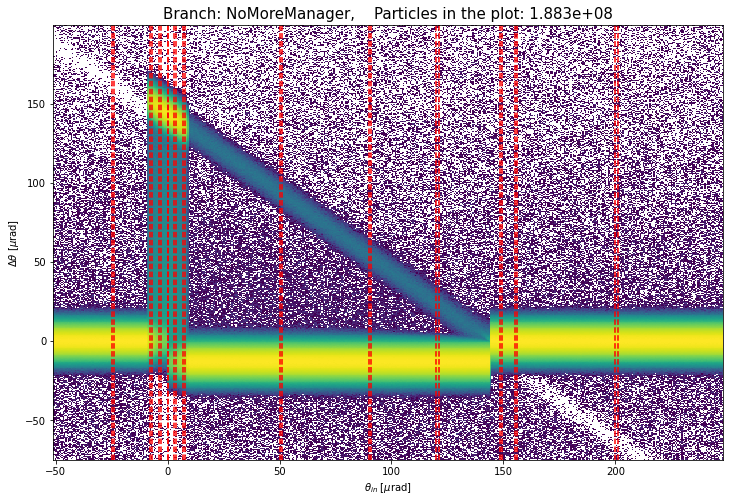

In [21]:
plt.figure(figsize=(12,8))

slices = [[-0.001, 0.001, 'CH_0'], [50, 51, 'VR'], [155, 156, 'TR VR-AM_2'], [3, 4, 'CH'], [-4, -3, 'CH'], [7,8, 'CH'], [-8, -7, 'CH'], [-25, -24, 'AM_1'], 
            [90, 91, 'VR'], [200, 201, 'AM_2'], [148.5, 149.5, 'TR'], [120,121, 'VR']]

slices = sorted(slices)
_ = plt.hist2d(df.px_in*1.e6, df.px_diff*1.e6,500, norm=mpl.colors.LogNorm())
for sl in slices:
    plt.axvline(sl[0], color = 'r', linestyle='--')
    plt.axvline(sl[1], color = 'r', linestyle='--')
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.title(f'Branch: {branch_name},    Particles in the plot: {len(df.px_in):.3e}', fontsize=15)
#plt.tight_layout()
plt.savefig(f"Slices_2d_{branch_name}.png", dpi=300)

#### Slices Plot

In [ ]:
del df
gc.collect()

<Figure size 720x504 with 0 Axes>

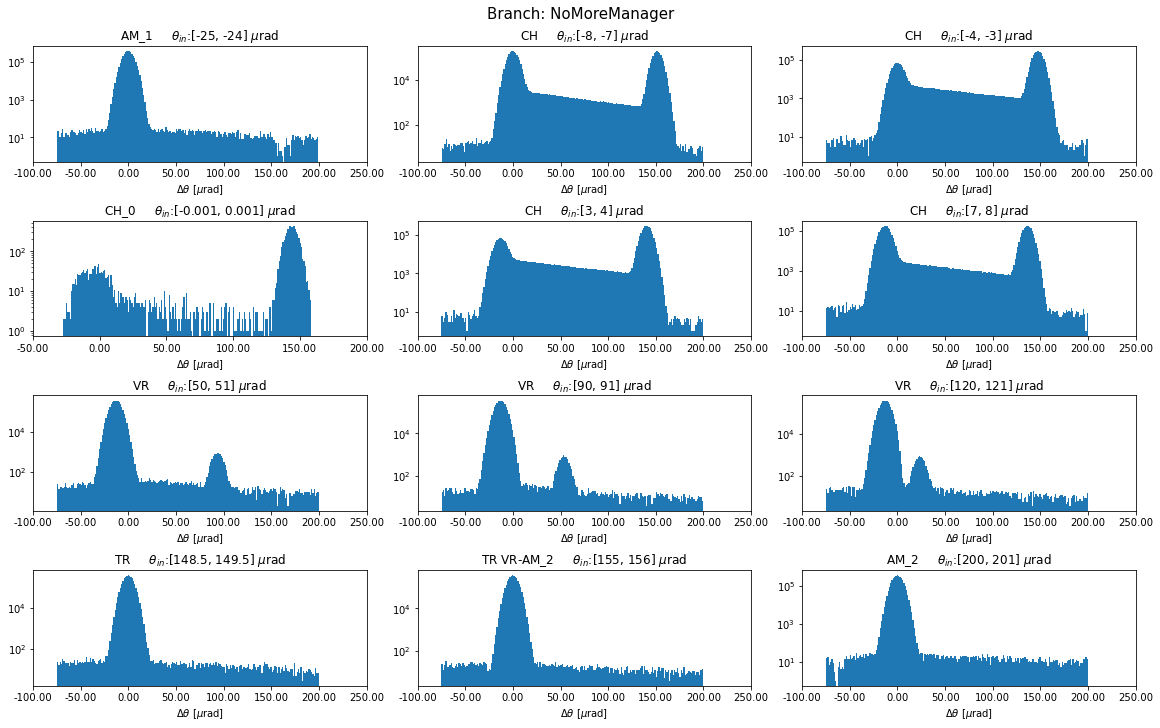

In [26]:

plt.figure(figsize=(10,7))

slices = [[-0.001, 0.001, 'CH_0'], [50, 51, 'VR'], [155, 156, 'TR VR-AM_2'], [3, 4, 'CH'], [-4, -3, 'CH'], [7,8, 'CH'], [-8, -7, 'CH'], [-25, -24, 'AM_1'], 
            [90, 91, 'VR'], [200, 201, 'AM_2'], [148.5, 149.5, 'TR'], [120,121, 'VR']]

slices = sorted(slices)
fig, ax= plt.subplots(4,3,layout='constrained',  figsize=(16,10))

for idx, a in enumerate(slices):  
    this_ax = ax[idx//3, idx%3]
    if slices[idx][0] in files.keys():
        df = load(slices[idx][0])
        this_ax.hist(df.px_diff, 200)
    else:
        df = load(int(np.floor(slices[idx][0])), int(np.ceil(slices[idx][1])))
        mask = (df.px_in > slices[idx][0]*1e-6) & (df.px_in < slices[idx][1]*1e-6)
        this_ax.hist(df.px_diff[mask], 200)
    this_ax.set_xticks(ticks=this_ax.get_xticks(), labels=[f"{x_tick*1e6:.{2}f}" for x_tick in this_ax.get_xticks()])
    this_ax.set_yscale('log')
    this_ax.set_title(f'{slices[idx][2]}'+ r'     $\theta_{in}$:' +f'[{slices[idx][0]}, {slices[idx][1]}' + r'] $\mu$rad')
    this_ax.set_xlabel(r'$\Delta\theta$ [$\mu$rad]')

fig.suptitle(f'Branch: {branch_name}',  fontsize=15)
fig.savefig(f"Slices_1d_{branch_name}.png", dpi=300)
    